## Exercise 1

Find an optimal learning rate for the handwriting MNIST data.  After this, verify that your learning rate achieves better performance than values that are either larger or smaller.

In [25]:
# Using Handwriting MNIST as a working example
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import math
import matplotlib.pyplot as plt
import numpy as np

mnist = mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

noise_factor = 1
X_train = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_valid = X_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_valid.shape) 
X_test = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

In [32]:

def build_model(seed=42):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer,n_epochs = 10):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=n_epochs,
                     validation_data=(X_valid, y_valid))


K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate=self.model.optimizer.learning_rate * self.factor
        
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                    max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    
    model.optimizer.learning_rate=min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate=init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses



def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()



430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1263 - loss: 2.7285


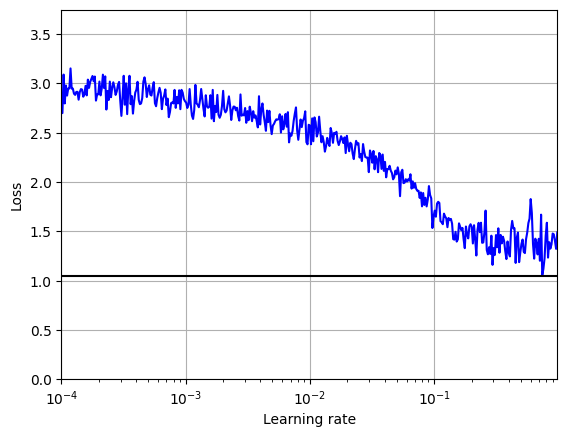

In [26]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [27]:
optimal_lr = 10**-.9
optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,metrics=["accuracy"])
history_optimal_lr = model.fit(X_train, y_train, epochs=20,
                     validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5652 - loss: 1.2804 - val_accuracy: 0.7508 - val_loss: 0.7577
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7560 - loss: 0.7244 - val_accuracy: 0.7544 - val_loss: 0.7558
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8077 - loss: 0.5592 - val_accuracy: 0.7498 - val_loss: 0.8392
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8459 - loss: 0.4473 - val_accuracy: 0.7368 - val_loss: 0.9697
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8701 - loss: 0.3702 - val_accuracy: 0.7350 - val_loss: 1.0600
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8879 - loss: 0.3216 - val_accuracy: 0.7210 - val_loss: 1.2569
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8955 - loss: 0.2940 - val_accuracy: 0.7266 - val_loss: 1.3485
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9076 - loss: 0.2634 - 

In [28]:
optimal_lr = 10**-4
optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,metrics=["accuracy"])
history_optimal_lr = model.fit(X_train, y_train, epochs=20,
                     validation_data=(X_valid, y_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9365 - loss: 0.2353 - val_accuracy: 0.7140 - val_loss: 2.8300
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9393 - loss: 0.2214 - val_accuracy: 0.7140 - val_loss: 2.8101
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9414 - loss: 0.2101 - val_accuracy: 0.7146 - val_loss: 2.7937
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9430 - loss: 0.2006 - val_accuracy: 0.7154 - val_loss: 2.7799
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9443 - loss: 0.1925 - val_accuracy: 0.7160 - val_loss: 2.7682
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9458 - loss: 0.1855 - val_accuracy: 0.7168 - val_loss: 2.7581
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9470 - loss: 0.1793 - val_accuracy: 0.7170 - val_loss: 2.7494
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9477 - loss: 0.1738 - 

In [29]:
optimal_lr =10**-.5
optimizer = tf.keras.optimizers.SGD(learning_rate=optimal_lr)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,metrics=["accuracy"])
history_optimal_lr = model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7626 - loss: 0.9726 - val_accuracy: 0.6214 - val_loss: 1.7304
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7576 - loss: 0.8835 - val_accuracy: 0.6868 - val_loss: 1.5937
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7896 - loss: 0.7508 - val_accuracy: 0.6958 - val_loss: 1.5801
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8079 - loss: 0.6973 - val_accuracy: 0.6930 - val_loss: 1.6206
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8126 - loss: 0.6801 - val_accuracy: 0.6972 - val_loss: 1.7954
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8169 - loss: 0.6900 - val_accuracy: 0.6772 - val_loss: 1.9191
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8203 - loss: 0.6631 - val_accuracy: 0.6766 - val_loss: 2.0563
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8153 - loss: 0.7029 - 

## Exercise 2

Compare a one cycle learning rate schedule to a power law schedule for the handwriting data.  Which can you make perform more effectively?

In [30]:
class PowerScheduling(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_rate, step_param):
        super(PowerScheduling, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_rate = decay_rate
        self.step_param = step_param

    def __call__(self, step):
        # Note the "cast" here - necessary to make sure we get the correct type back
        return self.initial_learning_rate / (1 + tf.cast(step, tf.float32) / self.step_param) ** self.decay_rate


# Example usage
initial_learning_rate = 0.1
decay_rate = 1.0  # For linear decay
step_param = 1000.0  # Determines how quickly the learning rate decreases

lr_schedule = PowerScheduling(initial_learning_rate, decay_rate, step_param)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5617 - loss: 1.2844 - val_accuracy: 0.7550 - val_loss: 0.7411
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7745 - loss: 0.6717 - val_accuracy: 0.7648 - val_loss: 0.7096
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8205 - loss: 0.5424 - val_accuracy: 0.7680 - val_loss: 0.7097
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8490 - loss: 0.4656 - val_accuracy: 0.7684 - val_loss: 0.7206
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8684 - loss: 0.4109 - val_accuracy: 0.7668 - val_loss: 0.7348
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8849 - loss: 0.3691 - val_accuracy: 0.7640 - val_loss: 0.7511
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8977 - loss: 0.3355 - val_accuracy: 0.7634 - val_loss: 0.7684
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9095 - loss: 0.3081 - 

In [31]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate=lr

model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
optimal_lr = 10**-.9
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=optimal_lr)

history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2041 - loss: 2.2888 - val_accuracy: 0.5662 - val_loss: 1.2658
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5826 - loss: 1.2037 - val_accuracy: 0.6850 - val_loss: 0.9344
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6784 - loss: 0.9445 - val_accuracy: 0.7126 - val_loss: 0.8608
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7189 - loss: 0.8382 - val_accuracy: 0.7234 - val_loss: 0.8343
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7431 - loss: 0.7644 - val_accuracy: 0.7278 - val_loss: 0.8209
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7684 - loss: 0.6960 - val_accuracy: 0.7326 - val_loss: 0.8173
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7919 - loss: 0.6274 - val_accuracy: 0.7332 - val_loss: 0.8176
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8143 - loss: 0.5581 - val_accuracy: 0.

## Exercise 3

Re-run all of the code in the second notebook with the handwriting data, instead of the fashion data; graph your losses (training and validation).  Do you achieve similar results?

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1403 - loss: 2.5553 - val_accuracy: 0.2526 - val_loss: 2.0965
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2871 - loss: 2.0025 - val_accuracy: 0.3810 - val_loss: 1.7411
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.4129 - loss: 1.6778 - val_accuracy: 0.4814 - val_loss: 1.4709
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4990 - loss: 1.4416 - val_accuracy: 0.5406 - val_loss: 1.2935
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5523 - loss: 1.2869 - val_accuracy: 0.5800 - val_loss: 1.1806
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5890 - loss: 1.1839 - val_accuracy: 0.6078 - val_loss: 1.1050
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6148 - loss: 1.1104 - val_accuracy: 0.6276 - val_loss: 1.0513
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6362 - loss: 1.0548 - 

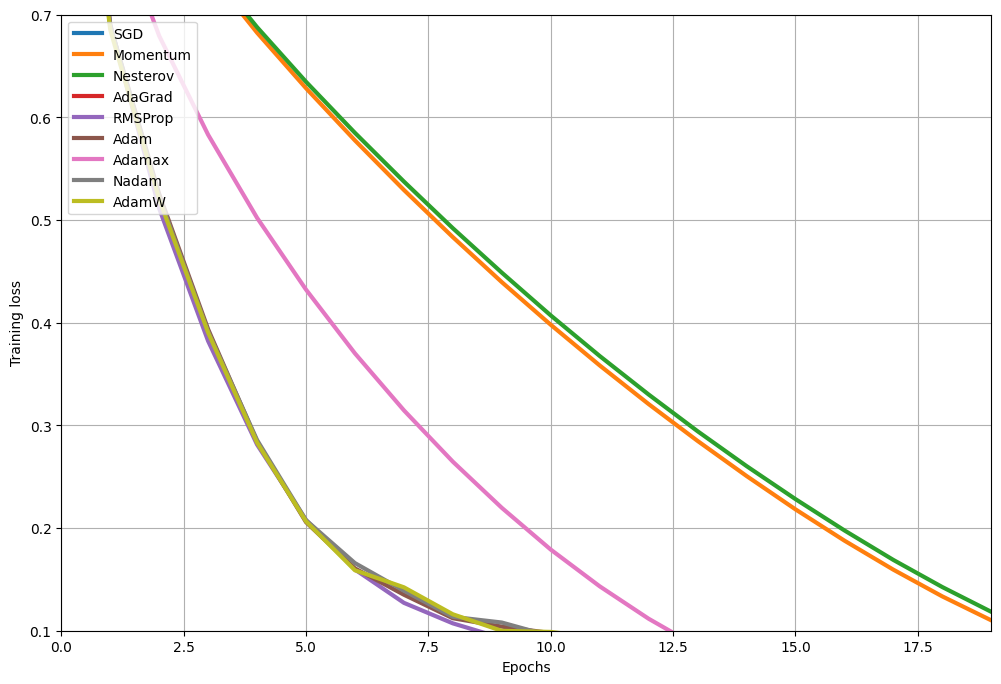

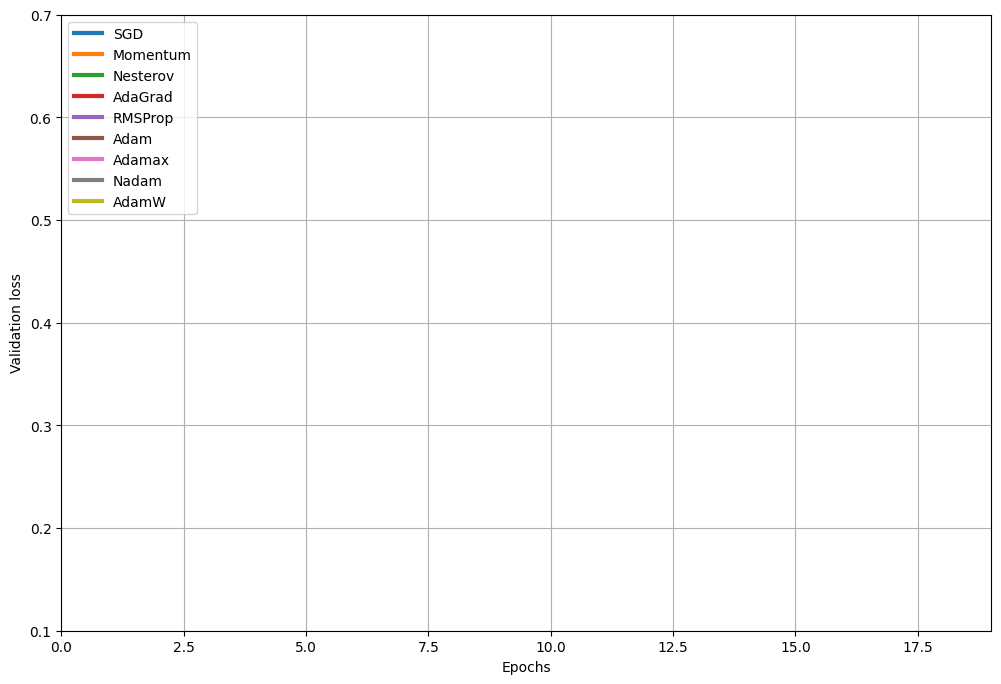

In [33]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
history_sgd = build_and_train_model(optimizer,n_epochs=20)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=.9)
history_momentum = build_and_train_model(optimizer,n_epochs=20)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

history_nesterov = build_and_train_model(optimizer,n_epochs=20)
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer,n_epochs=20)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer,n_epochs=20)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)
history_adam = build_and_train_model(optimizer,n_epochs=20)
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)
history_adamax = build_and_train_model(optimizer,n_epochs=20)
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)
history_nadam = build_and_train_model(optimizer,n_epochs=20)
optimizer = tf.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer,n_epochs=20)

import matplotlib.pyplot as plt




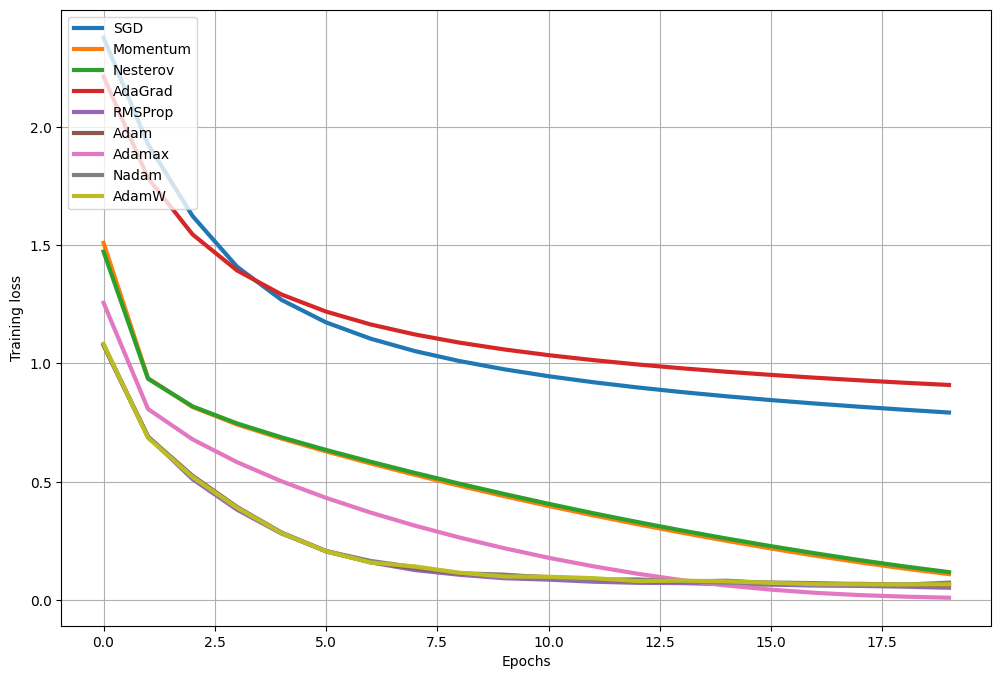

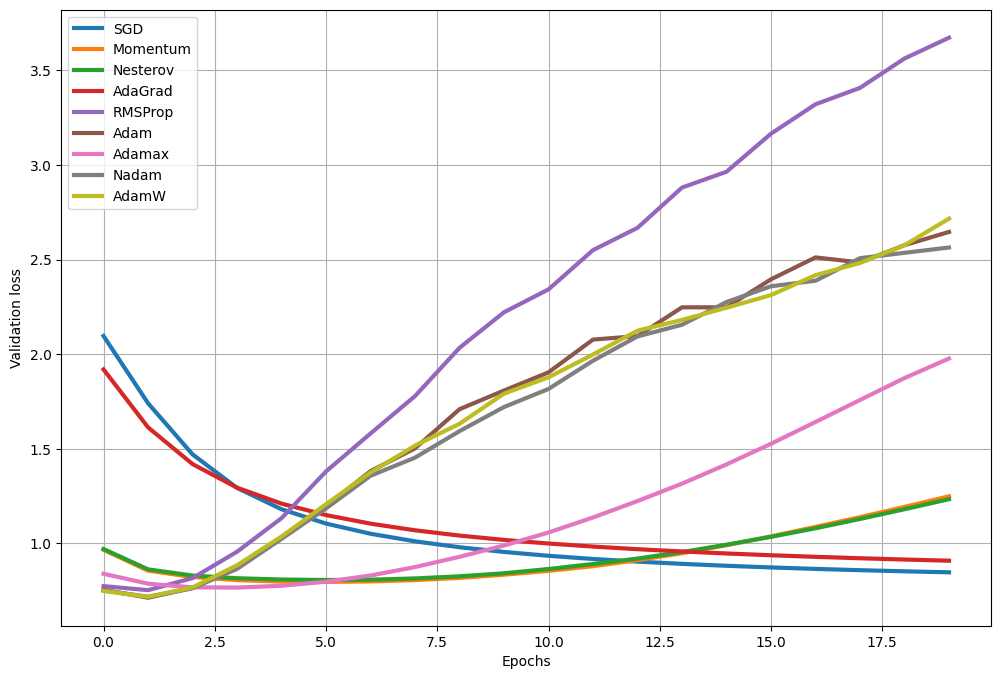

In [34]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
   
    plt.show()

## Exercise 4

Sometimes, adaptive optimizers fail, and non-adaptive optimizers like NAG or SGD perform a lot better.  This is sometimes the case with noisy data.

In the following, I've create a simple framework to examine the behavior of different optimizers with different noise levels.  Try running with an adaptive optimizer (AdamW) and a non-adaptive optimizer (NAG / SGD) with different levels of noise.  Do you find a point with NAG starts to outperform AdamW?  What happens if you adjust learning rates?

In [41]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add noise
noise_factor = 1
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)

train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

# Define a simple neural network model
def create_model(optimizer):
    tf.keras.backend.clear_session()
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model


def build_and_train_model(optimizer,n_epochs=10):
    print(f"Optimizer name {optimizer.name}")
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=n_epochs,
                     validation_data=(X_valid, y_valid))



In [40]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

history_nesterov = build_and_train_model(optimizer,n_epochs=20)

Optimizer name SGD
Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.3256 - loss: 1.9376 - val_accuracy: 0.6636 - val_loss: 0.9763
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6696 - loss: 0.9740 - val_accuracy: 0.7098 - val_loss: 0.8617
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7226 - loss: 0.8280 - val_accuracy: 0.7178 - val_loss: 0.8316
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7507 - loss: 0.7479 - val_accuracy: 0.7248 - val_loss: 0.8171
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7716 - loss: 0.6856 - val_accuracy: 0.7310 - val_loss: 0.8087
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7912 - loss: 0.6307 - val_accuracy: 0.7360 - val_loss: 0.8038
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8085 - loss: 0.5797 - val_accuracy: 0.7404 - val_loss: 0.8039
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.825

In [39]:
optimizer = tf.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer,n_epochs=20)

Optimizer name adamw
Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5398 - loss: 1.3457 - val_accuracy: 0.7486 - val_loss: 0.7514
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7609 - loss: 0.7092 - val_accuracy: 0.7700 - val_loss: 0.7072
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8227 - loss: 0.5361 - val_accuracy: 0.7658 - val_loss: 0.7511
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8660 - loss: 0.4066 - val_accuracy: 0.7556 - val_loss: 0.8490
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9053 - loss: 0.2977 - val_accuracy: 0.7466 - val_loss: 0.9848
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9285 - loss: 0.2193 - val_accuracy: 0.7394 - val_loss: 1.1933
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9436 - loss: 0.1676 - val_accuracy: 0.7326 - val_loss: 1.3453
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9